In [1]:
import datetime
import os
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import shutil

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    SHConfig,
)
import geopandas as gpd

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

c:\Users\Pavel\Documents\GitHub\runaway-satellite-detection\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
resolution = 10
config = SHConfig()

In [4]:
gdf = gpd.read_file('train/pac_2024_training.shp')

In [4]:
def get_bbox(coords):
    coords = np.array(coords)
    x_coords, y_coords = coords[:, 0], coords[:, 1]

    # Calculate the center of the polygon
    center_x, center_y = np.mean(x_coords), np.mean(y_coords)

    # Calculate the bounding box
    min_x, max_x = np.min(x_coords), np.max(x_coords)
    min_y, max_y = np.min(y_coords), np.max(y_coords)

    # Calculate the current width and height of the bounding box
    width, height = max_x - min_x, max_y - min_y
    
    # Use the larger dimension to make a square
    half_side = 3.5 * max(width, height)

    # Calculate the top-left and bottom-right points of the square
    top_left = (center_x - half_side, center_y + half_side)
    bottom_right = (center_x + half_side, center_y - half_side)

    return BBox(bbox=[top_left[0], top_left[1], bottom_right[0], bottom_right[1]], crs=CRS.WGS84)

In [5]:
def get_image(path, coords, time):
    bbox = get_bbox(coords)
    size = bbox_to_dimensions(bbox, resolution=resolution)
    evalscript_true_color = """
        //VERSION=3

        function setup() {
            return {
                input: [{
                    bands: ["B02", "B03", "B04"]
                }],
                output: [
                {
                    id: "default",
                    bands: 3,
                    sampleType: SampleType.AUTO,
                },
                {
                    id: "image",
                    bands: 3,
                    sampleType: SampleType.AUTO,
                }]
            };
        }

        function evaluatePixel(sample) {
            return {
                default: [4*sample.B04, 4*sample.B03, 4*sample.B02],
                image: [4*sample.B04, 4*sample.B03, 4*sample.B02],
            };
        }
    """

    return SentinelHubRequest(
        data_folder = os.path.join(path, time[0] + '_' + time[1]),
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time,
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG),
                   SentinelHubRequest.output_response("image", MimeType.TIFF)],
        bbox=bbox,
        size=size,
        config=config,
    )

In [6]:
def extract_and_remove_tar_files(parent_directory):
    # Iterate through all directories in the specified parent directory
    for root, dirs, files in os.walk(parent_directory):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)

            # Get the list of files and directories inside the subdirectory
            sub_items = os.listdir(dir_path)
            
            inner_dir = os.path.join(dir_path, sub_items[0])
            
            if os.path.isdir(inner_dir):
                tar_file = os.path.join(inner_dir, "response.tar")
                
                if os.path.isfile(tar_file):
                    try:
                        with tarfile.open(tar_file, "r") as tar:
                            tar.extractall(path=dir_path)

                        os.remove(tar_file)
                        shutil.rmtree(inner_dir)
                    except Exception as e:
                        print(f"Error processing {tar_file}: {e}")

In [7]:
for idx, row in gdf.iterrows():
    coords = row['geometry'].coords

    year = row['yr']
    start = datetime.datetime(year - 1, 9, 1)
    end = datetime.datetime(year + 1, 5, 31)
    n_chunks = 16
    tdelta = (end - start) / n_chunks
    edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
    slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]
    
    path = os.path.join('data', str(idx))
    os.makedirs(path, exist_ok=True)

    list_of_requests = []
    for slot in slots:
        list_of_requests.append(get_image(path, coords, slot))
    list_of_requests = [request.download_list[0] for request in list_of_requests]

    data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=20, show_progress=True)

    extract_and_remove_tar_files(path)

100%|██████████| 1/1 [00:04<00:00,  4.21s/it]


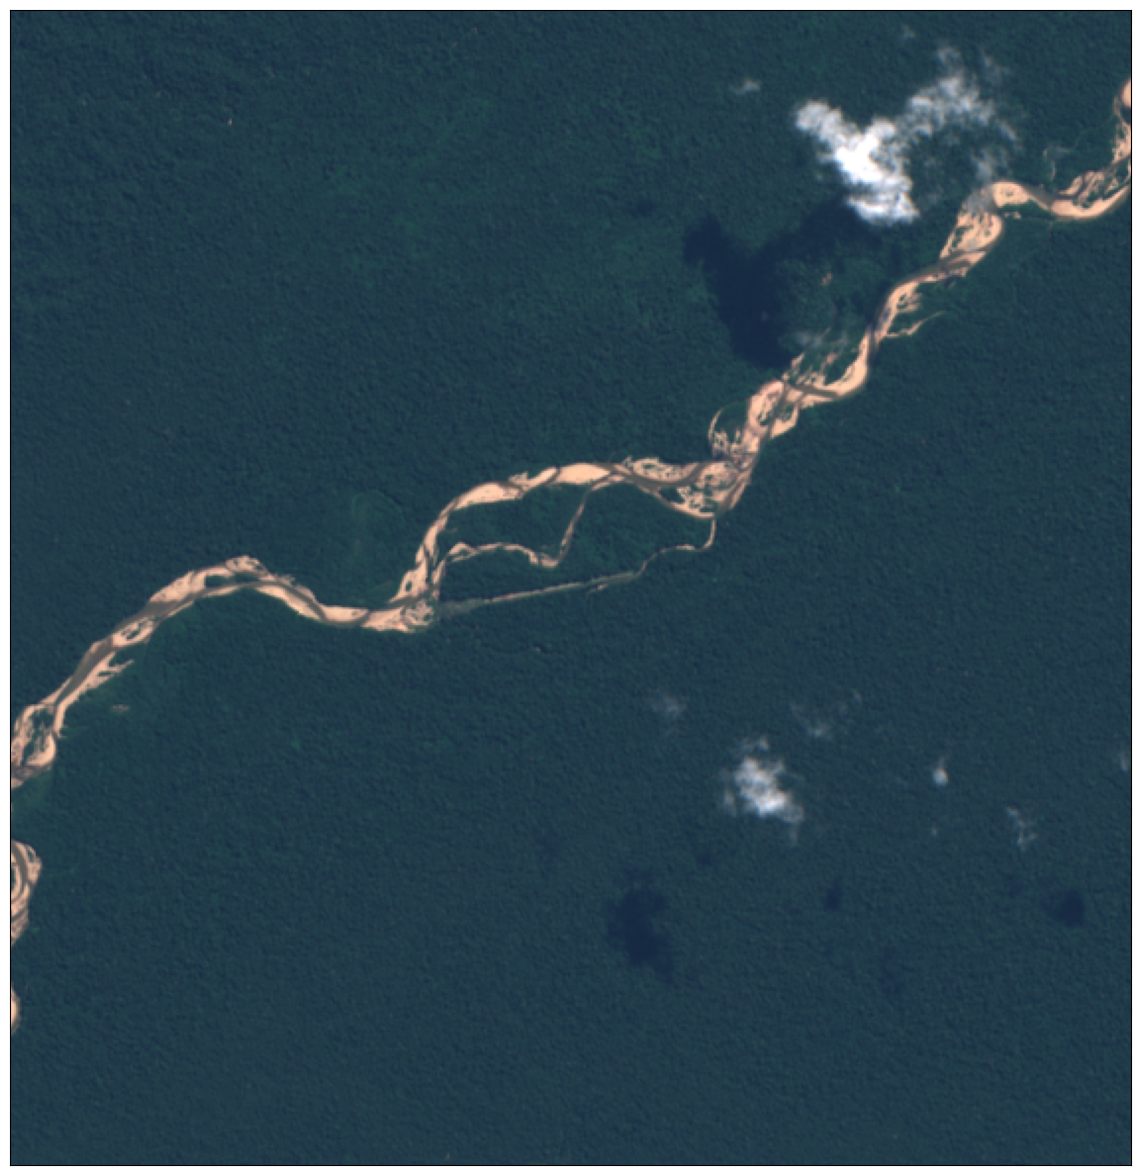

In [8]:
for image in data:
    plot_image(image['image.tif'], factor=1 / 255, clip_range=(0, 1))

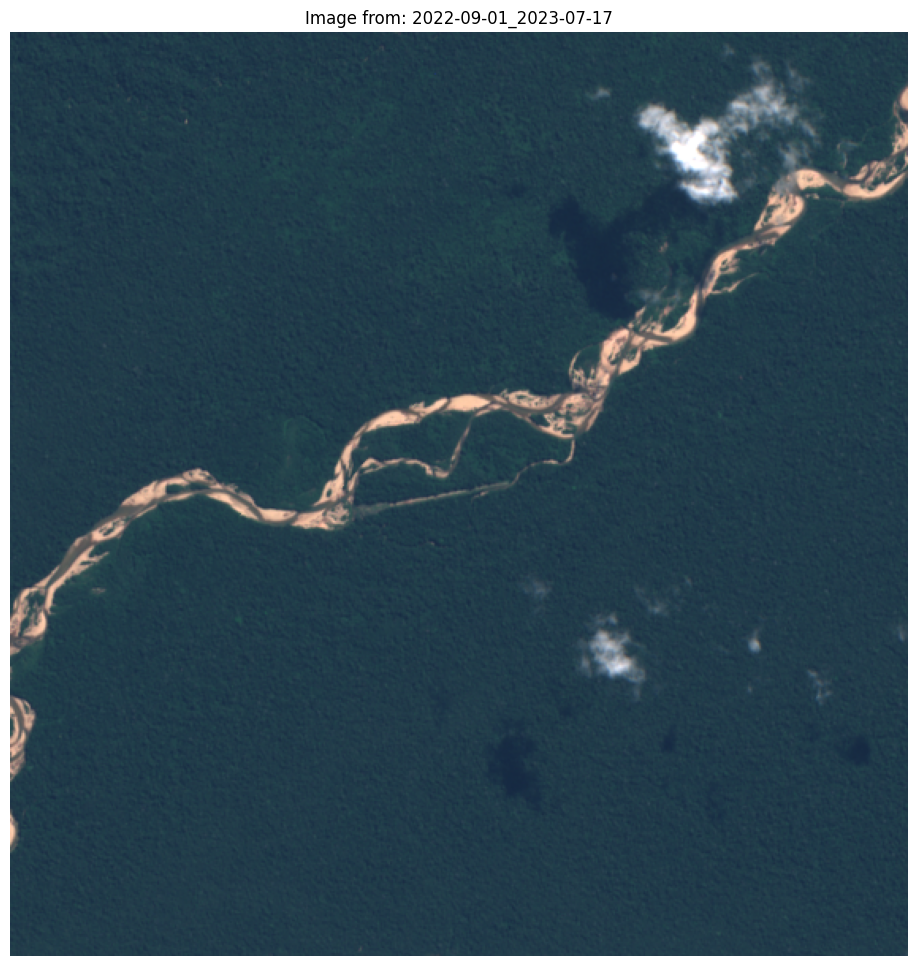

In [9]:
import matplotlib.image as mpimg
for root, dirs, files in os.walk("data/0"):
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        
        # List all files in the subdirectory
        sub_files = os.listdir(dir_path)
        
        # Look for a PNG file in the subdirectory
        for file in sub_files:
            if file.lower().endswith(".png"):
                png_file_path = os.path.join(dir_path, file)
                try:
                    plt.figure(figsize=(16, 12))
                    # Load and plot the PNG file
                    img = mpimg.imread(png_file_path)
                    plt.imshow(img)
                    plt.title(f"Image from: {dir_name}")
                    plt.axis('off')  # Turn off axes
                    plt.show()
                except Exception as e:
                    print(f"Error displaying {png_file_path}: {e}")
                break  # Stop after finding the first PNG file